# Figure showing the integrated approach results for the CD4 lineage

Summary figure of IA CD4 T cell results. This figure shows:

* Clustered data and fits to timeseries of model III
* IA clusters and fits
* Parameter estimates

It combines the clustering, fitting, and validation analysis in a single figure. Some validation is moved to an SI figure.
To run this notebook, first execute the notebook `IntegratedApproachCD4.ipynb` to get the required pickle!

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import json
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib

import scdynsys.plots as plots
import scdynsys.utilities as utils

import importlib
importlib.reload(plots)

tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)

tabcolors =  [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

## Import data required for the figure.

The CD4 figure combines some of the fitting and validation steps (that were shown in separate figures for the CD8 analysis)
Thereofore, we have to import two different data sets.

In [2]:
data_file_fit = "../results/data_IA_fitting_CD4.pkl"

with open(data_file_fit, 'rb') as f:
    data_dict_fit = pickle.load(f)

raw_latent_umap = data_dict_fit["raw_latent_umap"]
sel_markers = data_dict_fit["sel_markers"]
raw_data = data_dict_fit["raw_data"]
MFI = data_dict_fit["MFI"]
raw_clus = data_dict_fit["raw_clus"]
umap_sampled_per_clus = data_dict_fit["umap_sampled_per_clus"]
clus_relabel_dict = data_dict_fit["clus_relabel_dict"]
sample_density_umap = data_dict_fit["sample_density_umap"]
T0 = data_dict_fit["T0"]
ts_raw = data_dict_fit["ts_raw"]
yhats_raw = data_dict_fit["yhats_raw"]
raw_count_data_combined = data_dict_fit["raw_count_data_combined"]
clus_freq_array = data_dict_fit["clus_freq_array"]
weights_raw = data_dict_fit["weights_raw"]
unique_batch = data_dict_fit["unique_batch"]
batch_day_dict = data_dict_fit["batch_day_dict"]
ysims_raw = data_dict_fit["ysims_raw"]
count_scaling = data_dict_fit["count_scaling"]

rho_sam = data_dict_fit["rho_sam"]
loc_rho_sam = data_dict_fit["loc_rho_sam"]
eta_sam = data_dict_fit["eta_sam"]
loc_eta_sam = data_dict_fit["loc_eta_sam"]
Qsams = data_dict_fit["Qsams"]


num_clus = len(clus_relabel_dict)
clus_sorted_by_size = sorted(list(range(num_clus)), key=lambda x: clus_relabel_dict[x])

num_markers = len(sel_markers)

print("order of clusters:", clus_sorted_by_size)

order of clusters: [10, 5, 6, 4, 1, 7, 8, 2, 3, 0, 11, 9]


In [3]:
# import validation data

data_file_vali = "../results/data_IA_validation_CD4.pkl"

with open(data_file_vali, 'rb') as f:
    data_dict_vali = pickle.load(f)
    
# unpack

idxs_mix = data_dict_vali["idxs_mix"]
flat_umap_samples = data_dict_vali["flat_umap_samples"]
umap_samples_sim = data_dict_vali["umap_samples_sim"]
umap_samples_data = data_dict_vali["umap_samples_data"]
densities_per_frame_sim = data_dict_vali["densities_per_frame_sim"]
densities_per_frame_data = data_dict_vali["densities_per_frame_data"]
clus_sorted_by_size = data_dict_vali["clus_sorted_by_size"]
transformed_samples_per_clus = data_dict_vali["transformed_samples_per_clus"]
marker_expression_sim = data_dict_vali["marker_expression_sim"]
marker_expression_data = data_dict_vali["marker_expression_data"]
raw_data = data_dict_vali["raw_data"]
raw_recon = data_dict_vali["raw_recon"]
R2s_recon = data_dict_vali["R2s_recon"]
sel_markers = data_dict_vali["sel_markers"]
unique_samping_day = data_dict_vali["unique_sampling_day"]


## Give names to clusters / populations

these names will be used in the figure

The names will also be used in SI figures, so we save them to a pickle.

In [4]:
cluster_names = [
    "TRM 1",
    "TRM 2",
    "TEM 1",
    "Tfh",
    "TRM 3",
    "TRM 4",
    "TEM 2",
    "TRM 5",
    "TRM 6",
    "TCM",
    "TRM 7",
    "TRM 8",  
]

cluster_descriptions = {
    "TRM 1" : ("TRM 1 (CD49a$^\\text{hi}$)", "bl"),
    "TRM 2" : ("TRM 2\n(CXCR6$^\\text{hi}$ FR4$^\\text{hi}$)", "bl"),
    "TEM 1" : ("TEM 1 (CD27$^\\text{hi}$)", "tr"),
    "Tfh"   : ("Tfh (FR4$^\\text{hi}$)", "tl"),
    "TRM 3" : ("TRM 3\n(CD27$^\\text{hi}$ FR4$^\\text{hi}$)", "tr"),
    "TRM 4" : ("TRM 4\n(CD49a$^\\text{hi}$ Bcl-2$^\\text{hi}$)", "br"),
    "TEM 2" : ("TEM 2 (Bcl-2$^\\text{hi}$)", "br"),
    "TRM 5" : ("TRM 5 (FR4$^\\text{hi}$)", "br"),
    "TRM 6" : ("TRM 6 (Bcl-2$^\\text{hi}$)", "tl"),
    "TCM"   : ("TCM (CD62L$^\\text{hi}$)", "tl"),
    "TRM 7" : ("TRM 7 (Klrg1$^\\text{hi}$)", "tr"),
    "TRM 8" : ("TRM 8 (CD103$^\\text{hi}$)", "tl")  
}

lineage = "CD4"

assert len(cluster_names) == num_clus, "check number of clusters and cluster names!"

# save the fancy population names for other figures

with open("../results/fancy_names_IA_CD4.pkl", 'wb') as f:
    pickle.dump(cluster_names, f)

## Create the matplotlib figure

This requires some creative use of `GridSpec`

In [5]:
axmul = 3
hsize = 14
hnum = 10 * axmul
vnum = 10 * axmul + 1

fig = plt.figure(figsize=(hsize, vnum * hsize / hnum))

gs = GridSpec(vnum, hnum)

labx, laby = -0.07, 1.05

fig.subplots_adjust(wspace=0.1, hspace=0.1)

<Figure size 1400x1446.67 with 0 Axes>

## Show the distribution of markers in the (umapped) latent space

In [6]:
axs_expr_umap = []

for i, m in enumerate(sel_markers):
    ax = fig.add_subplot(gs[0:axmul, i*axmul:(i+1)*axmul])
    axs_expr_umap.append(ax)
    xs = raw_latent_umap[:,0]
    ys = raw_latent_umap[:,1]
    zs = raw_data[:,i]
    ax.scatter(xs, ys, c=zs, linewidths=0, s=1, rasterized=True)
    ax.set_title(m)
    ax.set_xticks([])
    ax.set_yticks([])
    
axs_expr_umap[0].set_xlabel("UMAP 1")
axs_expr_umap[0].set_ylabel("UMAP 2")

# label

Ax = fig.add_subplot(gs[0:axmul, 0:3*axmul])
Ax.axis('off')
Ax.text(-0.1, 1.1, "A", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.1, 1.1, 'A')

## Show the GMM components

In [7]:
ax = fig.add_subplot(gs[1*axmul+1:4*axmul+1, 0:3*axmul])

clus_colors = np.array([tabcolors[clus_relabel_dict[i]] for i in raw_clus])
N = raw_data.shape[0]
perm = np.random.choice(N, N, replace=False)

ax.scatter(
    raw_latent_umap[perm, 0], 
    raw_latent_umap[perm, 1], 
    c=sample_density_umap[perm], linewidths=0, s=1,
    rasterized=True
)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

# save xlim and ylim for umap timeseries
xlim = ax.get_xlim()
ylim = ax.get_ylim()

## compute HPD regions of each cluster and draw contour
patches = []
for i, clus in enumerate(clus_sorted_by_size):
    t_sam = umap_sampled_per_clus[clus]["samples"]
    patch = plots.plot_hpd_contour(
        ax, t_sam, color=tabcolors[i], 
        linewidth=3
    )
    patches.append(patch)
    tloc_sam = umap_sampled_per_clus[clus]["loc"]    
    ax.scatter(tloc_sam[:,0], tloc_sam[:,1], color=tabcolors[i], s=1, rasterized=True)

# label
Ax = fig.add_subplot(gs[axmul+1:2*axmul+1, 0:3*axmul])
Ax.axis('off')
Ax.text(-0.1, 1.1, "B", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.1, 1.1, 'B')

## Heatmap of marker expression per cluster

In [8]:
ax = fig.add_subplot(gs[axmul+1:3*axmul+2, 3*axmul+1:5*axmul])

# move y-axis to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# make sure MFI is properly z-scored
MFI = sts.zscore(MFI, axis=0) ## axis=0 means standardize over the the cell types!

plots.simple_heatmap(ax, MFI[::-1,:], sel_markers, cluster_names[::-1])

for i, tick in enumerate(ax.get_yticklabels()):
    tick.set_rotation(-45)
    tick.set_color(tabcolors[num_clus-i-1])


#ax.set_ylabel(f"{lineage} T cell population")
ax.set_xlabel("Marker")

ax_heat = ax

# label

Ax = fig.add_subplot(gs[axmul+1:2*axmul+1, 3*axmul+1:6*axmul+1])
Ax.axis('off')
Ax.text(-0.1, 1.1, "C", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.1, 1.1, 'C')

## Parameter estimates

In [9]:
def plot_mpd(ax, pos, sam, xlabels):
    ax.violinplot(sam, positions=pos, showextrema=False)
    plots.simple_boxplot(ax, pos, sam.T)
    ax.set_xticks(pos)
    ax.set_xticklabels(xlabels, rotation=45, ha='right', fontsize='x-small')
    
def append_loc_to_sams(sams, locs):
    return np.concatenate([sams.T, np.expand_dims(locs, 1).T]).T

ylab_coord = -0.2

ax = fig.add_subplot(gs[axmul+1:2*axmul+1,6*axmul:7*axmul+2])
# paste loc param to unit params
rho = append_loc_to_sams(rho_sam[:, clus_sorted_by_size], loc_rho_sam)
lam_E = -rho
plot_mpd(ax, range(num_clus+1), lam_E, cluster_names + ["average"])
ax.axvline(num_clus-0.5, color='k', linewidth=0.5)
ax.set_ylabel(r'Net loss ($\lambda_E$)')
ax.yaxis.set_label_coords(ylab_coord, 0.5)

ax.set_yticks(np.linspace(-0.5, 1.0, 4))
ax.axhline(y=0, color='0.7', linestyle='--')


# label
Ax = fig.add_subplot(gs[axmul+1:2*axmul+1,6*axmul:8*axmul])
Ax.axis('off')
Ax.text(-0.1, 1.1, "D", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.1, 1.1, 'D')

## Plot Q matrix

In [10]:
ax = fig.add_subplot(gs[axmul+2:3*axmul+2,8*axmul+1:10*axmul])

unique_clus = list(range(num_clus))
cx = plots.plot_diff_matrix_vae(
    ax, Qsams, unique_clus, clus_sorted_by_size,
    {i : cluster_names[i] for i in unique_clus},
    cbar_loc='top', num_cticks=3, ctick_formatter="${:0.2f}$"
)

ax.set_xticks(np.array(range(num_clus)) + 0.5)
ax.set_yticks(np.array(range(num_clus)) + 0.5)

ax.set_xticklabels(cluster_names, rotation=45, ha='right', fontsize='x-small')
ax.set_yticklabels(cluster_names, rotation=45, fontsize='x-small')

ax.set_xlabel("Source")
ax.set_ylabel("Destination")

#cx = fig.colorbar(cs, ax=ax)
cx.set_label("Differentiation rate ($Q_{ij}$)")

# label
Ax = fig.add_subplot(gs[axmul+1:2*axmul+1,8*axmul+1:10*axmul])
Ax.axis('off')
Ax.text(-0.1, 1.1, "E", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.1, 1.1, 'E')

## Timeseries (counts)

In [11]:
tticks = [14, 28, 42, 56]

ax = fig.add_subplot(gs[3*axmul:4*axmul,6*axmul:7*axmul+2])

ts = np.array([x[0] for x in raw_count_data_combined])
ys = np.array([x[1] for x in raw_count_data_combined])
ax.scatter(T0 + ts, ys * count_scaling, s=10, color='k', zorder=4, linewidths=0)

yhat_med = np.median(yhats_raw, axis=0)
yhat_low = np.percentile(yhats_raw, axis=0, q=2.5)
yhat_high = np.percentile(yhats_raw, axis=0, q=97.5)

# credible envelope
ax.plot(T0 + ts_raw, yhat_med * count_scaling, color='blue', zorder=3)
ax.fill_between(
    T0 + ts_raw, yhat_low * count_scaling, yhat_high * count_scaling, 
    color='blue', zorder=2, linewidth=0, alpha=0.3
)

# posterior predictive envelope
ysim_low = np.percentile(ysims_raw, axis=0, q=2.5)
ysim_high = np.percentile(ysims_raw, axis=0, q=97.5)
ax.fill_between(
    T0 + ts_raw, ysim_low * count_scaling, ysim_high * count_scaling, 
    color='blue', zorder=1, linewidth=0, alpha=0.2
)


ax.set_yscale('log')

ax.set_xlabel("DPI")
ax.set_xticks(tticks)
ax.set_ylabel(f"{lineage}+ T cells in lung")
ax.yaxis.set_label_coords(ylab_coord, 0.5)


# label
ax.text(-0.1, 1.1, "F", fontsize='xx-large', transform=ax.transAxes)

ax_counts = ax

## Timeseries (freqs)

In [12]:
vstart = 4*axmul+2

ax_freq = fig.add_subplot(gs[vstart:vstart+2*axmul, 0:3*axmul])
plots.remove_axes_keep_labels(ax_freq)
ax_freq.set_ylabel(f"Fraction of cells\nin {lineage}+ T-cell population")    

axs = []

ylab_coord = -0.25


pos_arg_dict = {
    "bl" : dict(x=0.05, y=0.05, va="bottom", ha="left"),
    "tr" : dict(x=0.95, y=0.95, va="top", ha="right"),
    "tl" : dict(x=0.05, y=0.95, va="top", ha="left"),
    "br" : dict(x=0.95, y=0.05, va="bottom", ha="right")
}

for i, clus in enumerate(clus_sorted_by_size):
    color = tabcolors[i]
    u, v = divmod(i, 6)
    ax = fig.add_subplot(gs[vstart+u*axmul:vstart+(u+1)*axmul, v*5+1:(v+1)*5])
    axs.append(ax)
    xs = clus_freq_array[:,clus]
    ts = [batch_day_dict[b] for b in unique_batch]
    ax.scatter(ts, xs, color=color, s=10, zorder=3, linewidths=0)
    
    ws = weights_raw[:,:,clus]
    xhat_med = np.median(ws, axis=0)
    xhat_low = np.percentile(ws, axis=0, q=2.5)
    xhat_high = np.percentile(ws, axis=0, q=97.5)

    ax.plot(T0 + ts_raw, xhat_med, color=color, zorder=2)
    ax.fill_between(
        T0 + ts_raw, xhat_low, xhat_high, 
        color=color, alpha=0.3, zorder=1,
        linewidth=0
    )
    #ax.set_ylabel(cluster_names[i])
    #ax.yaxis.set_label_coords(ylab_coord, 0.5)
    clus_name = cluster_names[i]
    clus_descr, pos = cluster_descriptions[clus_name]
    pa = pos_arg_dict[pos]
    ax.text(s=clus_descr, **pa, transform=ax.transAxes, fontsize='small')
    
    # adjust font size of yticks
    ax.tick_params(axis='y', labelsize='x-small')
    if u == 0:
        ax.set_xticks([])
    else:
        ax.set_xticks(tticks)
        ax.set_xlabel("DPI")

# label

ax_freq.text(-0.1, 1.1, "G", fontsize='xx-large', transform=ax_freq.transAxes)

Text(-0.1, 1.1, 'G')

## Timeseries (UMAPs)

In [13]:
## plot a timeseries of simulated UMAP densities interleved with the data
vstart = 7*axmul+1

# ax for adding a panel label
Ax = fig.add_subplot(gs[vstart:vstart+axmul, :3*axmul])
Ax.axis('off')
Ax.text(-0.1, 1.1, "H", fontsize='xx-large', transform=Ax.transAxes)

# ax for adding xlabel and ylabel
Ax = fig.add_subplot(gs[vstart:vstart+3*axmul, :])
plots.remove_axes_keep_labels(Ax)
Ax.set_xlabel("UMAP 1")
Ax.set_ylabel("UMAP 2")


axs_frames = []

for i in range(len(idxs_mix)):
    a, b = divmod(i, hnum // axmul)
    ax = fig.add_subplot(gs[vstart+a*axmul:vstart+(a+1)*axmul, b*axmul:(b+1)*axmul])
    axs_frames.append(ax)

#xs, ys = flat_umap_samples[:,0], flat_umap_samples[:,1]
#xlim, ylim = (np.min(xs), np.max(xs)), (np.min(ys), np.max(ys))

for n, (t, i, s) in enumerate(idxs_mix):
    ax = axs_frames[n]
    if s == "sim":
        sams = umap_samples_sim[i]
        k = sams.shape[0]
        col_dens = densities_per_frame_sim[i]
        ax.scatter(sams[:,0], sams[:,1], s=1, c=col_dens, rasterized=True, linewidths=0)
    elif s == 'data':
        umap_day = umap_samples_data[i]
        col_dens = densities_per_frame_data[i]
        
        ax.scatter(umap_day[:,0], umap_day[:,1], s=1, c=col_dens, zorder=2, rasterized=True, linewidths=0)
        ax.axvspan(*xlim, color='0.8', linewidth=0, zorder=1)
    else:
        raise Exception("invalid frame type")
    ax.text(1.0,1.0,f"{t:0.1f}\nDPI", ha='right', va='top', transform=ax.transAxes)
    #ax.text(0.0,0.0,f"{t:0.1f}\nDPI", ha='left', va='bottom', transform=ax.transAxes)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.axis('off')

## Show the figure

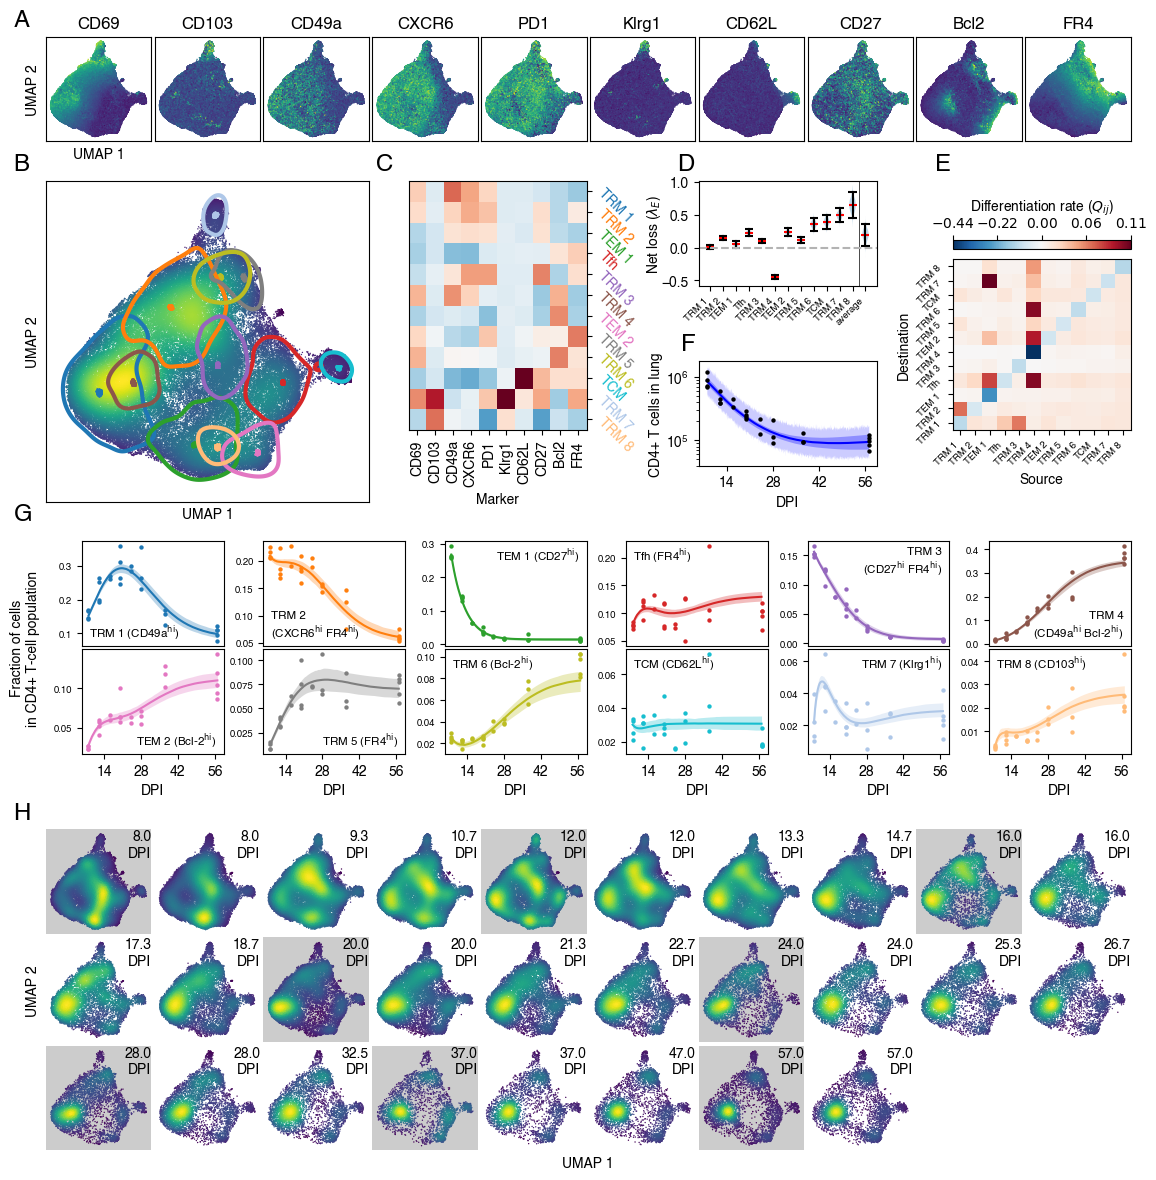

In [14]:
fig

In [15]:
#fig.savefig("../results/FigureIntegratedFitCD4.pdf", dpi=300, bbox_inches='tight')